## Initial test of apoptosis model - increasing Bcl2 copy number

In [1]:
using DifferentialEquations, DataFrames, Plots, CSV, Sundials, OrdinaryDiffEq, DelimitedFiles, JLD2, FileIO

In [2]:
#set up where CSV2Julia is
locationOfCSV2Julia="CSV2JuliaDiffEq/csv2model.py"

#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/apoptosis/reactions.csv"
parametersFile="moduleDefinitionFiles/apoptosis/parameters.csv"
rateLawsFile="moduleDefinitionFiles/apoptosis/rateLaws_apop.csv"

#build a command to execute csv2julia
location=[locationOfCSV2Julia]
arguments=[reactionsFile, parametersFile, rateLawsFile, "odeApoptosis.jl"]
cmd=`python $locationOfCSV2Julia $arguments`

#lets run csv2julia (requires python to be installed)
run(cmd)

inline
Running CSV2JuliaDiffEq with parameters hard-coded into the CSV file, if this is not correct, re-run with the 5th argument set to 'scan'
Opening moduleDefinitionFiles/apoptosis/rateLaws_apop_IC.csv as rate law file
Opening moduleDefinitionFiles/apoptosis/parameters_apop_IC.csv as parameters file
Opening moduleDefinitionFiles/apoptosis/reactions_apop_IC.csv as reactions file


Process(`python CSV2JuliaDiffEq/csv2model.py moduleDefinitionFiles/apoptosis/reactions_apop_IC.csv moduleDefinitionFiles/apoptosis/parameters_apop_IC.csv moduleDefinitionFiles/apoptosis/rateLaws_apop_IC.csv odeApoptosis.jl`, ProcessExited(0))

In [3]:
## Bcl2t values:

# WT  = 277
# 1.5 = 415.5
# 2.0 = 554
# 2.5 = 692.5
# 3.0 = 831
# 3.5 = 969.5

# replace xxx with value for copy number

function initConditionsApop(y0,syms)
   #units: M
   #source: the supplement of Albeck et al 2008 PLOS Biology
   y0[findfirst(isequal("L"),syms)]=0
   y0[findfirst(isequal("R"),syms)]=1000
   y0[findfirst(isequal("flip"),syms)]=2000
   y0[findfirst(isequal("pC8"),syms)]=10000
   y0[findfirst(isequal("BAR"),syms)]=1000
   y0[findfirst(isequal("pC3"),syms)]=10000
   y0[findfirst(isequal("pC6"),syms)]=10000
   y0[findfirst(isequal("XIAP"),syms)]=100000
   y0[findfirst(isequal("PARP"),syms)]=1000000
   y0[findfirst(isequal("Bid"),syms)]=60000
   y0[findfirst(isequal("Bcl2c"),syms)]=20000
   y0[findfirst(isequal("Bax"),syms)]=80000
   y0[findfirst(isequal("Bcl2"),syms)]=30000
   y0[findfirst(isequal("Mito"),syms)]=500000
   y0[findfirst(isequal("mCytoC"),syms)]=500000
   y0[findfirst(isequal("mSMac"),syms)]=100000
   y0[findfirst(isequal("Apaf"),syms)]=100000
   y0[findfirst(isequal("Procasp9"),syms)]=100000
   y0[findfirst(isequal("Bcl2t"),syms)]=277
   #this is new and will be replaced by cRel control in multiscale modeling
   return y0
end

initConditionsApop (generic function with 1 method)

In [4]:
## Files and variables required to solve
odeFile=include("modelFiles/apoptosis/odeApoptosisFixed.jl")
include("modelFiles/apoptosis/variableNamesApoptosis.jl")
p=1
maxTimeSS=100000.0
maxTimeTC=36*60.0
params=1


# fix species

include("utilityFunctions/fixSpecies.jl")
fixSpecies("modelFiles/apoptosis/odeApoptosis.jl","modelFiles/apoptosis/odeApoptosisFixed.jl",1)

Bcl2_doses=[277,415.5,554,692.5,831]

5-element Vector{Float64}:
 277.0
 415.5
 554.0
 692.5
 831.0

In [5]:
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms=Symbol.(syms)

59-element Vector{Symbol}:
 :L
 :R
 :L_R
 :DISC
 :flip
 :flip_DISC
 :pC8
 :DISC_pC8
 :C8
 :BAR
 :BAR_C8
 :pC3
 :pC3_C8
 ⋮
 :ASmac
 :cCytoC
 :Apaf
 :Apaf_cCytoC
 :ApafStar
 :Procasp9
 :Apop
 :Apop_pC3
 :cSmac
 :Apop_XIAP
 :cSmac_XIAP
 :Bcl2t

In [6]:
#y0[findfirst(isequal("Bcl2t"),syms)]=Bcl2_doses[i]

    #f=DDEFunction(ddeFile!,syms=syms)

    f=ODEFunction(odeFile,syms=syms)
    #print("Solving steady state with low input\n")

    prob=SteadyStateProblem(f,y0)
    @timev solss_x2=solve(prob,DynamicSS(Rodas5()),isoutofdomain=(y,p,t)->any(x->x<0,y))

    # save steady state
    #save("outputFiles/outputFiles/apoptosis/sol_Bcl2_WT.jld2", "solution", solss)

 43.290415 seconds (95.65 M allocations: 6.596 GiB, 4.88% gc time, 0.05% compilation time)
elapsed time (ns): 43290415128
gc time (ns):      2113463483
bytes allocated:   7081972705
pool allocs:       95615982
non-pool GC allocs:35802
malloc() calls:    281
realloc() calls:   10
GC pauses:         55
full collections:  3


u: 59-element Vector{Float64}:
      0.0
    200.1722913597829
      0.0
      0.0
    100.17728644168608
      0.0
  20213.761580968145
      0.0
      0.0
    610.8834444078675
      0.0
 619469.7374847665
      0.0
      ⋮
      0.0
      0.0
 100000.0
      0.0
      0.0
 100000.0
      0.0
      0.0
      0.0
      0.0
      0.0
    277.0

In [ ]:
dfss = DataFrame(solss_x2 = solss_x2.u)
insertcols!(dfss, 1, :names=>syms)

y0=solss_x2.u

In [ ]:
## PARP vs cPARP

#reimport variables names because we want a string again not a sym
include("modelFiles/apoptosis/variableNamesApoptosis.jl")

#find cleaved parp
speciesToPlot="CPARP"
#find total PARP
denominator=["PARP","PARP_C3","CPARP"]
varIndex=findfirst(isequal(speciesToPlot),syms)
denominatorIndexes=Array{Int64}(undef,length(denominator))
for i in 1:length(denominator)
    thisIndex=findfirst(isequal(denominator[i]),syms)
    denominatorIndexes[i]=convert(Int64,thisIndex)
end

#define the doses to scan


#store all the results in an array to plot at the end, faster than plotting in the loop.
cPARPArray=zeros(1,Int(maxTimeTC)+1)

    newInit=y0
    newInit[1]=y0[1]+1
    #we might use this later to remove Bcl2 survival signal
    #newInit[end]=2.77
    prob=ODEProblem(f,newInit,(0.0,maxTimeTC))
    sol=solve(prob,saveat=1.0,progress = true)

    #lets save this result in a csv file
    #df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    #CSV.write("outputFiles/apoptosis/out_"*string(i)*".csv",df)

    #calculate cleaved parp as a percentage of total and store in the array.
    thisNumerator=sol[varIndex,:] #cPARP
    thisDenominatorTCs=sol[denominatorIndexes,:]
    thisDenominator=sum(thisDenominatorTCs,dims=1) #other PARP species
    parpPercentage=thisNumerator./thisDenominator'
    cPARPArray=[cPARPArray;parpPercentage']

#cut off the zero array
cPARPArray_x2=cPARPArray[2:end,:]

In [ ]:
cPARPArray

In [ ]:
#palette=palette([:purple, :green],length(ligandDoses)),
plot(cPARPArray', legend=false)  #, labels=string.(ligandDoses'),legendtitle = "TRAIL",legend=:bottomright)
s=string.(collect(0:8:36))
plot!(xticks = (0:(60*8):(36*60),s), ylabel="cPARP",xlabel="time h",fmt = :png)
#plot!(cPARPArray_x2')

In [ ]:
## Wild type: Bcl2t value = 277

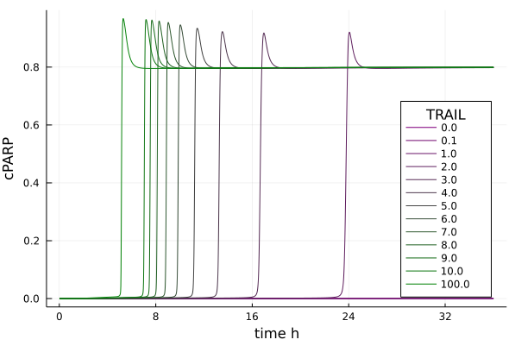

In [ ]:
## One extra copy: Bcl2t value = 415.5

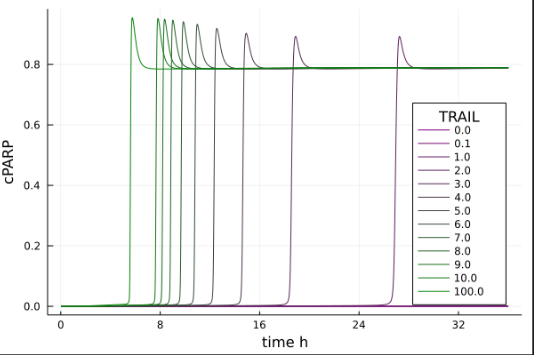

In [ ]:
# Cell death delayed when Trail ligand levels are < 2

In [ ]:
## Two extra copies: Bcl2t value = 554

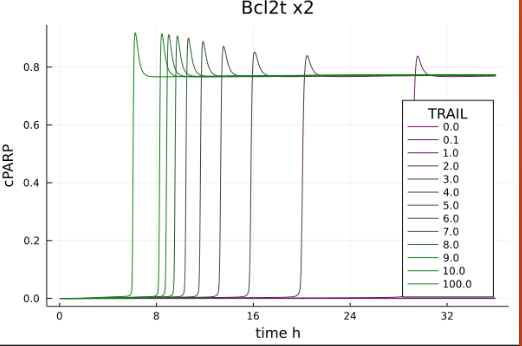

In [ ]:
# Cell death delayed for all levels of Trail ligand & max level of cleaved PARP reduced

In [ ]:
## 2.5 extra copies: Bcl2t value = 692.5

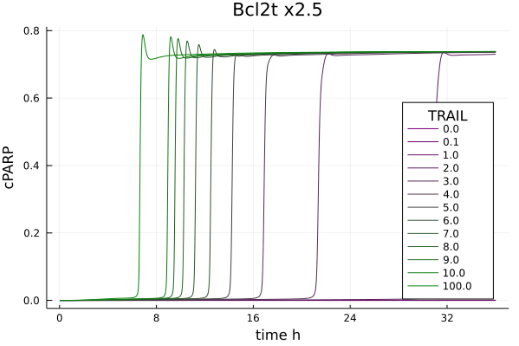

In [ ]:
# Further cell death delay & max cPARP level < 0.8

In [ ]:
## 3 extra copies: Bcl2t value = 831

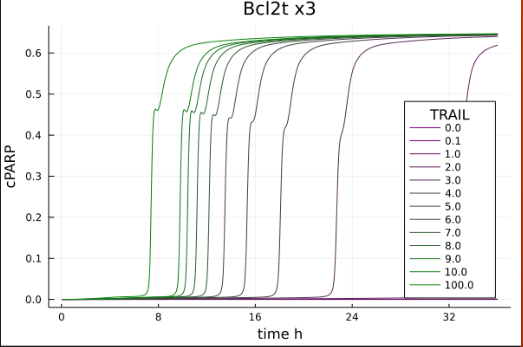

In [ ]:
# Further cell death delay & max cPARP level ~ 0.6

In [ ]:
## 3.5 extra copies: Bcl2t value = 969.5

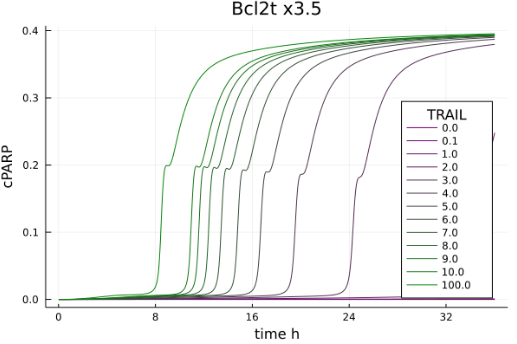

In [ ]:
# max cPARP level ~ 0.4

In [ ]:
## find point at which cPARP > 0.5 for each value of Ligand
cPARP_int_df = DataFrame(Time = Int[])
## find max value of cPARP
cPARP_max_df5 = DataFrame(Max = Float64[])

#cPARP_int_df[!,:col] = 0

for i in 1:13
   row = cPARPArray[i,:]
   PARP50 = findfirst(x->x>5e-1, row)
   PARPmax = maximum(row)
   if !isnothing(PARP50)
      push!(cPARP_int_df, [PARP50])
   end
   push!(cPARP_max_df5, [PARPmax])
end

#else
#   push!(cPARP_int_df2, [Float64(0)])

In [ ]:
# convert to array
cPARP_int_array = Matrix(cPARP_int_df)

cPARP_int_arrays = hcat(cPARP_int_arrays, cPARP_int_array)

# plot TRAIL vs time
# remove zero times
ligandDoses_nozero=[2,3,4,5,6,7,8,9,10,100]
ligandDoses_nozero=Array(ligandDoses_nozero)
log_lig_dose = log.(ligandDoses_nozero)


plot(cPARP_int_arrays, log_lig_dose, label=["WT" "1.5" "2" "2.5" "3"])
s=string.(collect(0:8:36))
plot!(xticks = (0:(60*8):(36*60),s), title="TRAIL vs time for Bcl2t copy numbers", ylabel="log10 TRAIL",xlabel="time of 50% PARP cleavage",fmt = :png)

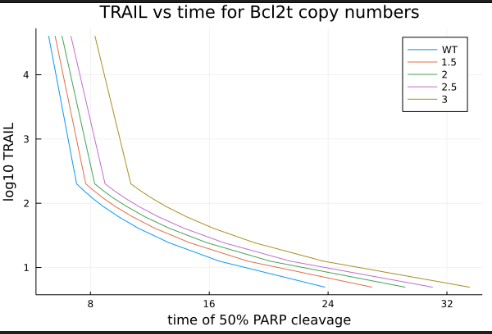

In [ ]:
cPARP_max = hcat(Matrix(cPARP_max_df), Matrix(cPARP_max_df2), Matrix(cPARP_max_df3), Matrix(cPARP_max_df4), Matrix(cPARP_max_df5))

plot(cPARP_max, ligandDoses, label=["WT" "1.5" "2" "2.5" "3"], legend=:topleft)
s=string.(collect(0:8:36))
plot!(title="TRAIL vs time (to max cPARP) for Bcl2t copy numbers", ylabel="TRAIL",xlabel="time h",fmt = :png)

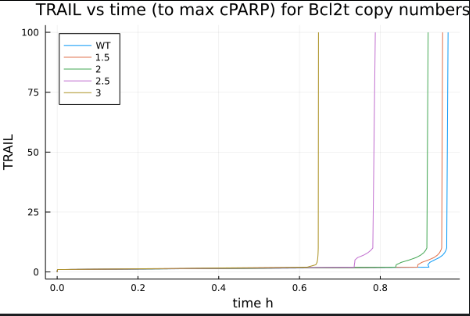